# **Stellar Object Classification**
_John Andrew Dixon_

---

#### **Data Dictionary**

|**Column Name**|**Description**| 
|-|-|
|obj_ID|Object Identifier, the unique value that identifies the object in the image catalog used by the CAS|
|alpha|Right Ascension angle (at J2000 epoch)|
|delta|Declination angle (at J2000 epoch)|
|u|Ultraviolet filter in the photometric system|
|g|Green filter in the photometric system|
|r|Red filter in the photometric system|
|i|Near Infrared filter in the photometric system|
|z|Infrared filter in the photometric system|
|run_ID|Run Number used to identify the specific scan|
|rereun_ID|Rerun Number to specify how the image was processed|
|cam_col|Camera column to identify the scanline within the run|
|field_ID|Field number to identify each field|
|spec_obj_ID|Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)|
|class|object class (galaxy, star or quasar object)|
|redshift|redshift value based on the increase in wavelength|
|plate|plate ID, identifies each plate in SDSS|
|MJD|Modified Julian Date, used to indicate when a given piece of SDSS data was taken|
|fiber_ID|fiber ID that identifies the fiber that pointed the light at the focal plane in each observation|

#### **Setup**

In [144]:
# Import the necessary libraries for analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [145]:
# Remote url to the dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRviGqwoVRVF_HY9LcyDLvVEDpdqZKvk1mL6K9xiWpEFh_i2QF4AX13P96L9F6nIAsD0iF0JZmcJ69A/pub?output=csv"
# Load the dataset.
df = pd.read_csv(url)
# Copy the loaded dataset so there is an origina copy and a copy to use for EDA and Machine Learning
stellar_df = df.copy()
# Verify it loaded
df.sample(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
8254,1.237679e+18,8.899850,18.425040,20.65131,20.38429,20.28979,20.19236,19.93100,7912,301,6,213,8.543416e+18,QSO,2.026830,7588,56903,318
45257,1.237663e+18,242.187274,57.077529,23.73433,23.04072,22.75126,21.75240,19.71882,4011,301,5,58,9.082807e+18,GALAXY,0.229701,8067,58253,627
21802,1.237670e+18,22.507177,6.263192,22.73929,21.37646,20.02594,19.17116,18.61528,5641,301,1,146,1.247051e+19,STAR,-0.000105,11076,58428,170
83819,1.237661e+18,147.231651,35.690445,20.73017,19.93065,19.80267,19.98851,19.69232,3647,301,3,67,5.148835e+18,QSO,2.390338,4573,55587,344
80820,1.237661e+18,124.029516,26.373375,21.19428,21.24986,20.90792,20.89157,21.26122,3605,301,4,104,1.252580e+19,QSO,1.233884,11125,58433,595


#### **Helper Functions**

In [146]:
# TBD

---
## **Explanatory Analysis**

#### **Cleaning**

**Duplicate check and removal:**

In [147]:
# Check for duplicates
stellar_df.duplicated().sum()

0

In [148]:
a = stellar_df.loc[stellar_df["obj_ID"].duplicated(keep="first"), :].iloc[0, 0]
stellar_df.loc[stellar_df["obj_ID"] == a, ]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
21,1.237658e+18,144.785293,46.826496,24.54793,22.33601,20.92259,19.87177,19.16934,2821,301,2,28,8.237292e+18,STAR,-0.000120,7316,56710,756
72,1.237658e+18,144.742439,46.967191,20.87676,20.61914,20.55744,20.54716,20.15146,2821,301,2,28,8.237289e+18,QSO,1.040196,7316,56710,745
157,1.237658e+18,144.811691,46.920477,24.45142,21.51859,20.46167,19.93067,19.51852,2821,301,2,28,8.237291e+18,STAR,-0.000186,7316,56710,755
1748,1.237658e+18,144.846089,47.005872,26.39015,22.00114,20.28762,19.15424,18.69907,2821,301,2,28,9.390415e+17,GALAXY,0.594444,834,52316,149
1771,1.237658e+18,144.866565,46.837194,22.50162,20.53223,18.90075,18.25920,17.92108,2821,301,2,28,8.386864e+18,GALAXY,0.321112,7449,56740,130


> There are no duplicates, meaning every row/sample of the original dataset represents a unique stellar object.

**Unnecessary column check and removal:**

In [149]:
stellar_df.nunique()

obj_ID         77332
alpha          99997
delta          99999
u              93748
g              92651
r              91901
i              92019
z              92007
run_ID           430
rerun_ID           1
cam_col            6
field_ID         856
spec_obj_ID    98431
class              3
redshift       94787
plate           6284
MJD             2180
fiber_ID        1000
dtype: int64

> As of right now, the only unnecessary column is `rerun_ID` because all 100,000 samples have the same value for this column. Keeping this column adds nothing.

In [150]:
stellar_df.drop(columns="rerun_ID", inplace=True)

**Categorical Inconsistencies check and fix:**

In [151]:
stellar_df["class"].value_counts(normalize=True)

GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: class, dtype: float64

> There are no categorical inconsistencies. Additionally, it's good to note that the classes are fairly unbalanced.

**Outlier check and fix:**

In [152]:
stellar_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237688e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,3.511610,186.130520,5.783893e+18,0.576661,5137.009660,55588.647500,449.312740
std,2.311265e+14,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,1.586912,149.011073,3.324026e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237669e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.240000e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


> There seem to be odd numbers within the `u`, `g`, and `z` features. All three have -9999 which does not seem to fit in with these features' stats. I'll explore further.

In [153]:
u_desc = df[["u"]].sort_values(by="u", ascending=False)
g_desc = df[["g"]].sort_values(by="g", ascending=False)
z_desc = df[["z"]].sort_values(by="z", ascending=False)
pd.concat([u_desc, g_desc, z_desc], axis=1)

,u,g,z
56693,32.78139,14.15644,13.76284
21245,30.66039,30.60700,16.82299
19525,29.32565,20.29043,26.13011
20225,29.23438,25.40505,23.54460
1046,29.19901,25.35543,17.17135
...,...,...,...
75620,12.30349,10.67180,10.65056
4472,12.26240,10.51139,10.22551
75784,12.10168,10.49820,10.44131
57763,10.99623,13.66217,11.30247


> It appears the -9999 in these three features is undoubtedly an outlier since it appears only once in all three features and the nearest number to it is a positive number. In fact, based on the outpute above, I believe these features should all be positive.

> There is not enough info present to fix the outlier, so I'll remove the corresponding row(s).

In [154]:
outliers = df.loc[df["u"] == -9999, :]
outliers

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
79543,1.237649e+18,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,301,2,537,3.731277e+18,STAR,0.000089,3314,54970,162


In [155]:
stellar_df.drop(outliers.index, inplace=True)
stellar_df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,2,581,1.060000e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


**Univariate visualizations:**

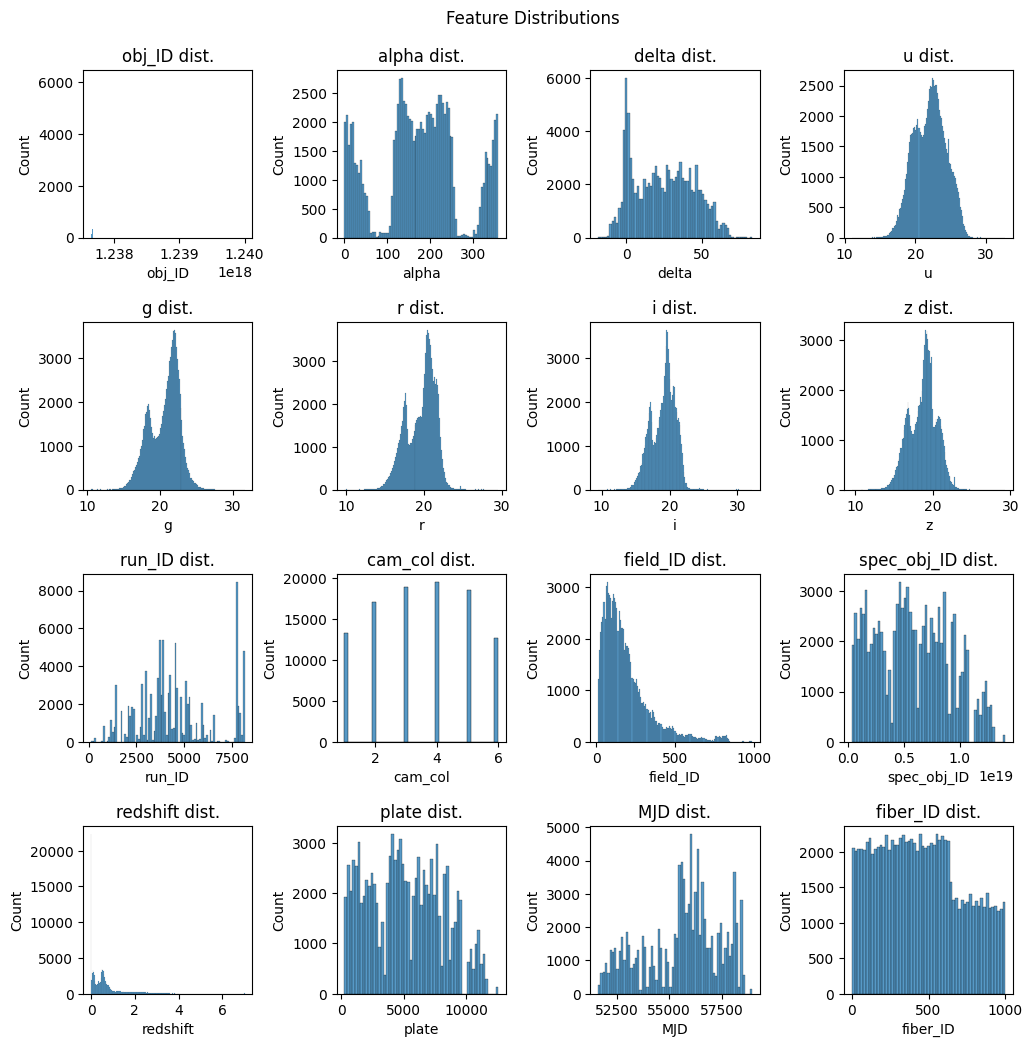

In [186]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
num_columns = stellar_df.drop(columns=["class"]).columns
# https://stackoverflow.com/questions/27371064/converting-a-1d-list-into-a-2d-list-with-a-given-row-length-in-python
num_columns = [num_columns[i:i+4] for i in range(0, len(num_columns), 4)]
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("Feature Distributions", y=0.93)
for row in range(4):
    for column in range(4):
        sns.histplot(data=stellar_df, x=num_columns[row][column], bins="auto", ax=axes[row, column]).set_title(f"{num_columns[row][column]} dist.")

Text(0.5, 1.0, 'Class frequency')

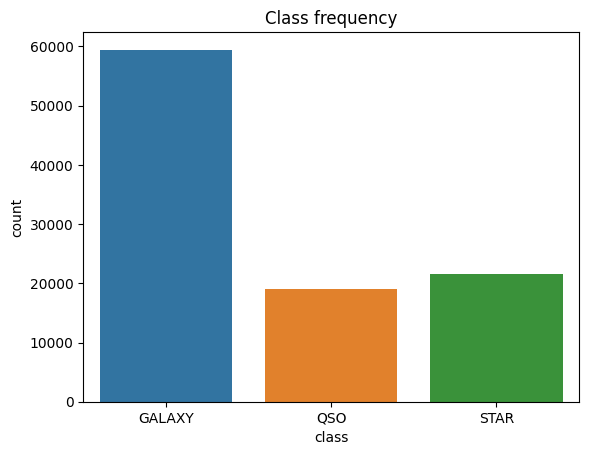

In [188]:
sns.countplot(data=stellar_df, x="class").set_title("Class frequency")

Personal Check-List:
- Implement some type of feature selection/engineering.
- Create simple imputers based on distributions.
- Check class imbalance and fix it if imbalanced.
- Train-test split with stratify so the testing data has good class balance.
- Implement some of project 2 rubric's recommendations.